In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.autograd.functional import jacobian

import matplotlib.pyplot as plt

device = 'cpu'

In [2]:
pts_d = torch.tensor([[102.0609359741211, 177.68905639648438], [100.3509292602539, 167.23500061035156], [99.89280700683594, 156.78094482421875], [101.36156463623047, 146.32687377929688], [104.38093566894531, 135.87437438964844], [108.5796890258789, 125.47187805175781], [115.23100280761719, 120.44978332519531], [122.27299499511719, 117.66829681396484], [129.4586944580078, 116.23683166503906], [136.64443969726562, 115.62409973144531], [143.8301239013672, 115.61384582519531], [151.00180053710938, 116.40960693359375], [158.1218719482422, 118.39375305175781], [168.01901245117188, 130.04348754882812], [177.69168090820312, 141.98281860351562], [185.921875, 154.31015014648438], [191.02603149414062, 166.83958435058594], [191.53152465820312, 178.95571899414062], [187.47500610351562, 189.70938110351562], [177.13729858398438, 193.73788452148438], [166.42343139648438, 194.9875030517578], [155.6437530517578, 195.05859375], [144.85781860351562, 194.2820281982422], [134.07186889648438, 192.50546264648438], [123.28593444824219, 189.5535125732422], [112.59375, 184.89999389648438]])

In [3]:
pts_d = pts_d.to(device)
print(pts_d.shape)

torch.Size([26, 2])


pts_d torch.Size([26, 2])
pts_d_ torch.Size([26, 2])
l1 torch.Size([26, 1])
val_d torch.Size([2, 26])
torch.Size([1, 2, 128, 128])


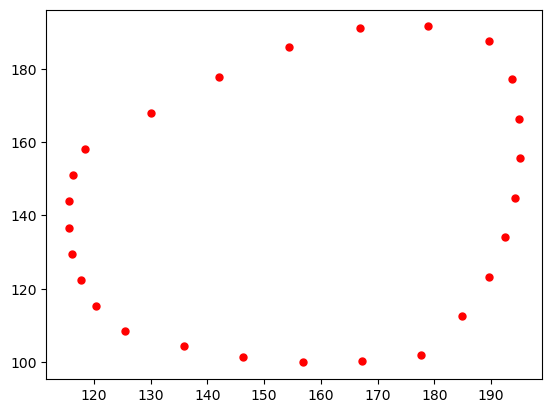

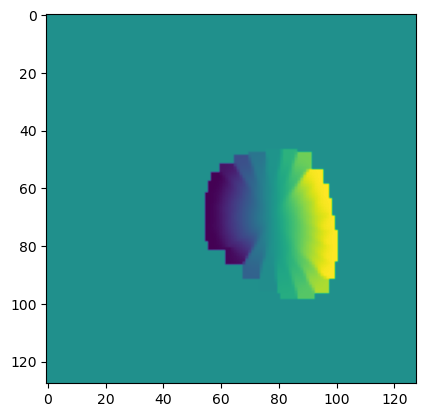

In [7]:
class InverseGridSampler(Function):
    @staticmethod
    def forward(ctx, input, grid, shape, mode, padding_mode, align_corners):
        ctx.save_for_backward(input, grid)
        ctx.mode = mode
        ctx.padding_mode = padding_mode
        ctx.align_corners = align_corners
        
        dtype = input.dtype
        device = input.device
        output = -jacobian(lambda x: (F.grid_sample(x, grid, mode, padding_mode, align_corners) - input).pow(2).mul(0.5).sum(), torch.zeros(shape, dtype=dtype, device=device))
        
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, grid = ctx.saved_tensors
        mode = ctx.mode
        padding_mode = ctx.padding_mode
        align_corners = ctx.align_corners
        
        B, C = input.shape[:2]
        input_shape = input.shape[2:]
        grad_output_shape = grad_output.shape[2:]

        y = jacobian(lambda x: F.grid_sample(grad_output.unsqueeze(2).view(B * C, 1, *grad_output_shape), x, mode, padding_mode, align_corners).mean(), grid.unsqueeze(1).repeat(1, C, *([1] * (len(input_shape) + 1))).view(B * C, *input_shape, len(input_shape))).view(B, C, *input_shape, len(input_shape))
        grad_grid = (input.numel() * input.unsqueeze(-1) * y).sum(1)
        
        grad_input = F.grid_sample(grad_output, grid, mode, padding_mode, align_corners)
        
        return grad_input, grad_grid, None, None, None, None

def inverse_grid_sample(input, grid, shape, mode='bilinear', padding_mode='zeros', align_corners=True):
    return InverseGridSampler.apply(input, grid, shape, mode, padding_mode, align_corners)

def filter1D(img, weight, dim, padding_mode='replicate'):
    B, C = img.shape[:2]
    dims = img.shape[2:]
    N = weight.shape[0]
    
    padding = torch.zeros(2 * len(dims),)
    padding[[2 * len(dims) - 2 - 2 * dim, 2 * len(dims) - 1 - 2 * dim]] = N//2
    padding = padding.long().tolist()
    
    view = torch.ones(2 + len(dims),)
    view[dim + 2] = -1
    view = view.long().tolist()
    
    if len(dims) == 2:
        return F.conv2d(F.pad(img.view(B*C, 1, *dims), padding, mode=padding_mode), weight.view(view)).view(B, C, *dims)
    
    if len(dims) == 3:
        return F.conv3d(F.pad(img.view(B*C, 1, *dims), padding, mode=padding_mode), weight.view(view)).view(B, C, *dims)
    
class GaussianSmoothing(nn.Module):
    def __init__(self, sigma):
        super(GaussianSmoothing, self).__init__()
        
        sigma = torch.tensor([sigma])
        N = torch.ceil(sigma * 3.0 / 2.0).long().item() * 2 + 1
    
        weight = torch.exp(-torch.pow(torch.linspace(-(N // 2), N // 2, N), 2) / (2 * torch.pow(sigma, 2)))
        weight /= weight.sum()
        
        self.weight = weight
        
    def forward(self, x):
        D = len(x.shape) - 2
        device = x.device
        
        for d in range(D):
            x = filter1D(x, self.weight.to(device), d)
        
        return x
    
def reconstruct_kpts(kpts, label, shape, scale=1, mode='bilinear', padding_mode='zeros', align_corners=True, normalise=False):
    _, N, C = label.shape
    B, _, D = kpts.shape
    device = kpts.device
    
    shape_scaled = (shape * scale).round().long()
    
    kpts_view = [B, *[1 for _ in range(D-1)], N, D]
    label_view = [B, -1, *[1 for _ in range(D-1)], N]
    
    if normalise:
        rec = inverse_grid_sample(homogenous(label).permute(0, 2, 1).view(label_view), kpts_pt(kpts, shape).view(kpts_view), (B, C+1, *(shape_scaled)), mode, padding_mode, align_corners)
        rec = rec[:, :-1] / (rec[:, -1:] + 1e-8)
    else:
        rec = inverse_grid_sample(label.permute(0, 2, 1).view(label_view), kpts_pt(kpts, shape).view(kpts_view), (B, C, *(shape_scaled)), mode, padding_mode, align_corners)
    
    return rec

smooth_c = nn.Sequential(GaussianSmoothing(1.2))
    
def pts2uv(pts_d):
    plt.figure()
    plt.plot(pts_d[:, 1].cpu(), pts_d[:, 0].cpu(), 'r.', markersize=10)
    mean_d = pts_d.mean(0,keepdim=True)
    pts_d_ = pts_d-mean_d
    l1 = pts_d_.abs().max(-1,keepdim=True).values
    val_d = (pts_d_/l1).t()
    
    print('pts_d', pts_d.shape)
    print('pts_d_', pts_d_.shape)
    print('l1', l1.shape)
    print('val_d', val_d.shape)
    
    for i in range(1,20):
        pts_d = torch.cat((pts_d,pts_d_*i/20+mean_d),0)
        val_d = torch.cat((val_d,(pts_d_*i/20/l1).t()),1)
    val_d = torch.cat((val_d,torch.ones(1,len(pts_d)).to(device)))
    
    uv1 = smooth_c(reconstruct_kpts(pts_d.unsqueeze(0), val_d.t().unsqueeze(0), torch.tensor([256,256]).to(device), scale=0.5, normalise=True))
    uv1 = uv1[:,:2]/(uv1[:,2:]+1e-6)
    return uv1

def kpts_pt(kpts_world, shape):
    device = kpts_world.device
    return (kpts_world.flip(-1) / (shape.flip(-1) - 1)) * 2 - 1

def homogenous(kpts):
    B, N, _ = kpts.shape
    device = kpts.device
    return torch.cat([kpts, torch.ones(B, N, 1, device=device)], dim=2)

uv1 = pts2uv(pts_d)
print(uv1.shape)

plt.figure()
#plt.imshow(uv1[0, 0].cpu())
plt.imshow(uv1[0, 1].cpu())
plt.show()

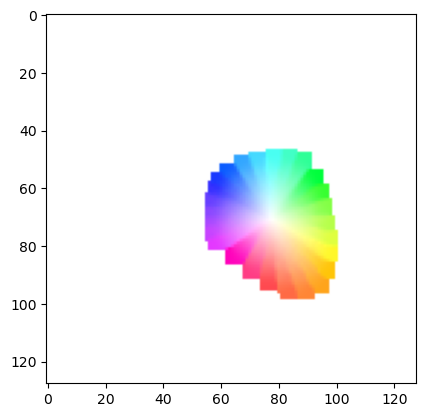

In [5]:
import cv2
import numpy as np

def flow2img(flow, BGR=True):
	x, y = flow[0, 0,:,:], flow[0, 1, :, :]
	hsv = np.zeros((flow.shape[2], flow.shape[3], 3), dtype = np.uint8)
	ma, an = cv2.cartToPolar(x, y, angleInDegrees=True)
	hsv[..., 0] = (an / 2).astype(np.uint8)
	hsv[..., 1] = (cv2.normalize(ma * 52, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)).astype(np.uint8)
	hsv[..., 2] = 255
	img = []
	if BGR:
		img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
		return img
	else:
		img[0] = cv2.cvtColor(x, cv2.COLOR_HSV2RGB)
		img[1] = cv2.cvtColor(y, cv2.COLOR_HSV2RGB)
		return img
    
plt.figure()
plt.imshow(flow2img(uv1.cpu().numpy()))
plt.show()

In [6]:
(uv1[0, 1].max())

tensor(1.0000)